Number of detected contours 13
3.045453421044641
Grain 1: Length = 2.97 mm
Grain 2: Length = 2.93 mm
Grain 3: Length = 2.89 mm
Grain 4: Length = 2.92 mm
Grain 5: Length = 3.07 mm
Grain 6: Length = 2.84 mm
Grain 7: Length = 2.81 mm
Grain 8: Length = 2.77 mm
Grain 9: Length = 3.02 mm
Grain 10: Length = 2.93 mm
Grain 11: Length = 2.79 mm
Grain 12: Length = 2.90 mm
Grain 13: Length = 3.05 mm
[13, 3.05, 0, [2.97, 2.93, 2.89, 2.92, 3.07, 2.84, 2.81, 2.77, 3.02, 2.93, 2.79, 2.9, 3.05]]


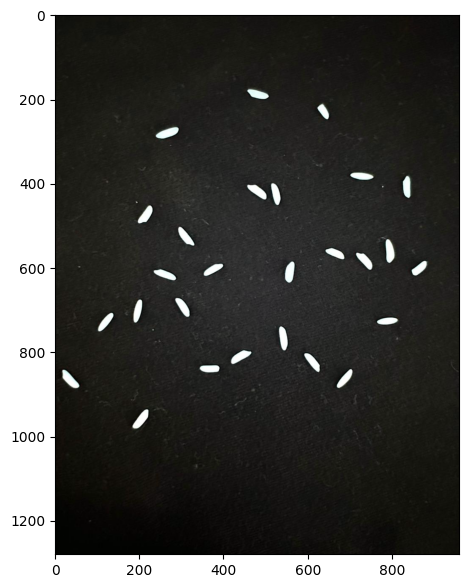

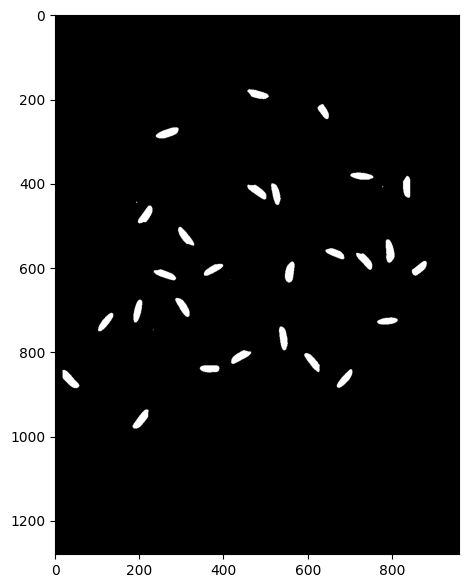

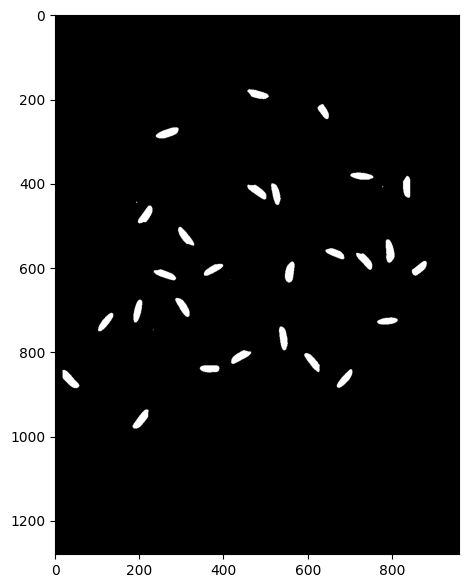

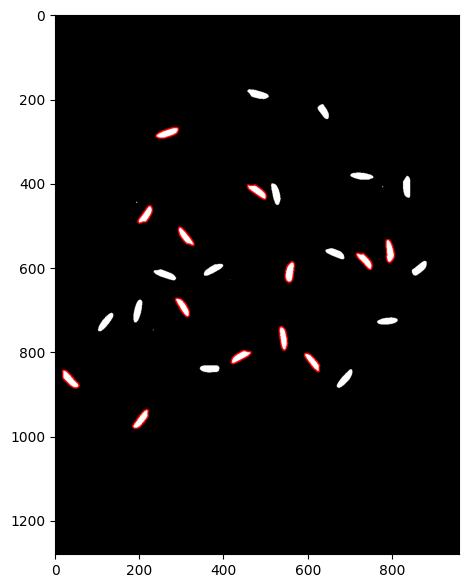

In [11]:
import cv2 as cv 

# Importing numpy for working with numpy arrays
import numpy as np 

# Importing pyplot as plt from maplotlib for Image Visualization
from matplotlib import pyplot as plt 
# git commit
#Importing PIL library for working with Images
from PIL import Image 

#Importing asarray method from numpy for dealing with pixels of Images
from numpy import asarray 

import matplotlib.image as mpimg

#Importing ndimage from scipy as this package contains various functions for multidimensional image processing.
from scipy import ndimage

#Importing filters, features, measures and color from skimage
from skimage import filters, feature, measure, color

#Importing Watershed for touching Grains sepration
from skimage.segmentation import watershed

#Importing for standardizing the Rice grains 
from sklearn.preprocessing import MinMaxScaler

#Importing to draw charts
import matplotlib.pyplot as plt

from skimage.measure import label

#Defining show function for displaying  image with custom X and Y cordinates

def show(image,x=30,y=7):
#   img=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  plt.figure(figsize=(x,y))
  plt.imshow(image,cmap="gray")

def pipeline(image_path):
    img = cv.imread(image_path)
    show(img,20,7)
    #Converting Image BGR Image to Gray for Image thresholding and further Image-Preprocessing application
    
    grayscale_Image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    th, thresh_img = cv.threshold(grayscale_Image, 140, 255, cv.THRESH_BINARY)

    show(thresh_img)
    sharp_img = cv.Laplacian(thresh_img, cv.CV_64F)
    sharp_img = np.uint8(np.absolute(sharp_img))

    sharpened_image = cv.addWeighted(thresh_img, 1.2, sharp_img, -0.2, 0)

    ret, thresh_sharpened = cv.threshold(sharpened_image, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

    show(thresh_sharpened)
    
    kernel = np.ones((3),np.uint8)
    clear_image = cv.morphologyEx(thresh_img,cv.MORPH_OPEN, kernel, iterations=8)
    # kernel = np.ones((4,4),dtype = np.uint8)
    # clear_image = cv.dilate(clear_image,kernel,iterations = 2)
    # clear_image = cv.erode(clear_image,kernel,iterations = 2)
    show(clear_image)
    return clear_image

def newFindContors(clear_image):
    contours, hierarchy = cv.findContours(clear_image,cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    output_contour = cv.cvtColor(clear_image, cv.COLOR_GRAY2BGR)
    cv.drawContours(output_contour, contours, -1, (255, 0, 0), 2)
    min_area_threshold = 700

    filtered_contours = []

    for contour in contours:
        area = cv.contourArea(contour)
        if area > min_area_threshold :
            filtered_contours.append(contour)

    output_contor = cv.cvtColor(clear_image, cv.COLOR_GRAY2BGR)
    cv.drawContours(output_contor, filtered_contours, -1, (255, 0, 0), 2)
    show(output_contor)
    print("Number of detected contours", len(filtered_contours))
    return filtered_contours

def Img_thresholding(img_path):
    # img = cv.imread(img_path)
    # show_and_save_image_with_axes(img_path)
    #Converting Image BGR Image to Gray for Image thresholding and further Image-Preprocessing application
    # grayscale_Image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # th, thresh_img = cv.threshold(grayscale_Image, 120, 255, cv.THRESH_BINARY)
    # #show(thresh_img)
    # grain_count,grain_area,broken_grain,Rice_area = remove_noise(thresh_img)    
    clear_image = pipeline(img_path)    
    filtered_contours = newFindContors(clear_image)
    grain_count = len(filtered_contours)
    avg_grain_length,brokenCount,Rice_lengths = count_grains(filtered_contours)
    # grain_count,grain_area,broken_grain,Rice_area = watershedalgo(modified_image)
    return [grain_count,round(avg_grain_length,2),brokenCount,Rice_lengths]
    
def remove_noise(thresh_img):
    # Noise removal
    kernel = np.ones((3),np.uint8)
    clear_image = cv.morphologyEx(thresh_img,cv.MORPH_OPEN, kernel, iterations=8)
    #Using show function earlier defined
    #show(clear_image)
    grain_count,grain_area,broken_grain,Rice_area = find_contours(clear_image)
    return grain_count,grain_area,broken_grain,Rice_area

# Image pre-processing is done now, and its time to apply the Grain counting algorithm.
# Counting the labels
def find_contours(clear_image):
    contours, hierarchy = cv.findContours(clear_image,cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    output_contour = cv.cvtColor(clear_image, cv.COLOR_GRAY2BGR)
    cv.drawContours(output_contour, contours, -1, (255, 0, 0), 2)
    print('Showing Contor')
    show(output_contour)
    grain_count,grain_area,broken_grain,Rice_area = get_rice_count(clear_image)
    return grain_count,grain_area,broken_grain,Rice_area


# STEP 4 - Counting rice grains using Contours method
# Applying Opencv Contour method for counting the total number of rice grains avilable in the image. \
# Contours are defined as the line joining all the points along the boundary of an image that are having the same intensity. 
#Applying Countours method to get the count of rice grains
def get_rice_count(clear_image):
    contours, hierarchy = cv.findContours(clear_image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    output_contour = cv.cvtColor(clear_image, cv.COLOR_GRAY2BGR)
    cv.drawContours(output_contour, contours, -1, (0, 0, 255), 2)
    print("Number of detected contours", len(contours))
    grain_count,grain_area,broken_grain,Rice_area = watershedalgo(clear_image)
    return  grain_count,grain_area,broken_grain,Rice_area

# Output_Contour Image Analysis
# Looking at the ouput_image after applying contours that, there are some rice grains that are touching each other. 
# And this situation making the Opencv Contour method to treat those images as collection or as 1 rice grain.
# Well the amount of grains that are touching each other are very few but still there needed a fix for this.
# Time to fix the touching Rice grain problem!

# Applying Watershed Algorithm 
# Fixing rice grains Touching problem with "**WaterShed Algorithm**" \
# Watershed algorithm is based on extracting sure background and foreground and then using markers will make watershed run and detect the exact boundaries. This algorithm generally helps in detecting touching and overlapping objects in image.

#To visualize the segmentation conveniently, There needed a colour-code the labelled regions using the color, thus I did it.
def watershedalgo(clear_image):
    # Compute the distance from non-zero (foreground) points to the nearest zero (background) point
    dist_trans = ndimage.distance_transform_edt(clear_image)

    #Applying peak_local_max function for getting coordinates of local peaks (maxima) in an image.
    local_max = feature.peak_local_max(dist_trans, min_distance=30)


    local_max_mask = np.zeros(dist_trans.shape, dtype=bool)
    local_max_mask[tuple(local_max.T)] = True

    #Aplying Watershed algorithm
    labels = watershed(-dist_trans, measure.label(local_max_mask), mask=clear_image) # separate merged corns

    Rice_area = []
    unique_labels = np.unique(labels)
    for label in unique_labels:
        if label == 0:  # Exclude the background label
            continue
        object_mask = labels == label
        area = np.sum(object_mask)
        if area < 30: # filter out small contours
            continue
        eq_diameter = np.sqrt(4 * area / np.pi)

        # Convert the equivalent diameter to millimeters
        #pixel_size = 0.10  # assume each pixel is 0.014 mm (you can adjust this based on your image)
        eq_diameter_mm = eq_diameter * 0.09
        Rice_area.append(round(eq_diameter_mm,2))
    count_grains(labels)
    grain_count,grain_area,broken_grain = count_broke_rice(Rice_area)
    # compare_images(clear_image,labels,local_max)
    return [grain_count,grain_area,broken_grain,Rice_area]


# ## STEP 6 - Counting Total Grains and Broken grains using grains area
# def count_grains(labels):
    #label2rgb function, specifying the background label with argument bg_label=0.
    # plt.figure(figsize=(30,10))
    # plt.imshow(color.label2rgb(labels, bg_label=0))
    # print("Number of Rice grains are : %d" % labels.max())
def count_grains(contours):
    scale = 3/32.8
    sum_len = []
    for i, contour in enumerate(contours):
        length = cv.arcLength(contour, True) * scale /4
        if(length > 3 and length < 20):
            sum_len.append(length)

    sum_len = np.array(sum_len)
    avg_grain_length = np.mean(sum_len)

    brokenCount = 0
    print(avg_grain_length)
    filtered_contours = []
    Rice_lengths = []
    decr = 0
    for i, contour in enumerate(contours):
        length = cv.arcLength(contour, True) * scale /4
        if avg_grain_length - 2 <= length and avg_grain_length * 1.5 > length:
            print(f"Grain {i+1}: Length = {length:.2f} mm")
            filtered_contours.append(contour)
            Rice_lengths.append(round(length,2))
        elif avg_grain_length * 1.5 < length:
            print(f"Outlier Grain {i+1}: Length = {length:.2f} mm")
            Rice_lengths.append(round(length,2))
        else:
            brokenCount +=1
            print(f"Possible Broken Grain {i+1}: Length = {length:.2f} mm")
            Rice_lengths.append(round(length,2))
            decr = decr+1
        # if avg_len * 1.5 > length:
        #     print(f"Grain {i+1-decr}: Length = {length:.2f} mm")

        # else:
        #     # print('Outlier')
        #     decr = decr+1
    return [avg_grain_length,brokenCount,Rice_lengths]

# STEP 6 - Counting Total Grains and Broken grains using grains area
def count_broke_rice(Rice_area_list):
    BrokenRiceCount=0;
    brokenRiceArea=0;
    TotalRiceAreaSum=0
    for rice in Rice_area_list:
        TotalRiceAreaSum+=rice
        if rice < 2.5:
            brokenRiceArea+=rice
            BrokenRiceCount+=1
            
    print("\nRice Analysis :")

    print("Total rice count is",(Rice_area_list))
        #Average area of rice 
    print("Average area of rice is: ", round(TotalRiceAreaSum/len(Rice_area_list),3)," mm")

    print("Broken Rice count is: ",BrokenRiceCount)

    print("Max & Minimum Rice Length: ",max(Rice_area_list),"mm",min(Rice_area_list),"mm")

    #Percentage of rice grain Broken
    print("Percentage of rice grain broken is :",round((brokenRiceArea/len(Rice_area_list)+brokenRiceArea),3),"% percent")

    return len(Rice_area_list),round(TotalRiceAreaSum/len(Rice_area_list),3),BrokenRiceCount


# ## Individual area of each rice grains
def rice_grain_count(Rice_area):
    print("\n\nTotal rice grain count as per contour is: ",len(Rice_area))
    Rice_area_list = Rice_area
    return Rice_area_list

def compare_images(clear_image,labels,local_max):
    # Visualization
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)
    ax[0].imshow(clear_image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(labels, cmap='nipy_spectral')
    ax[1].set_title('Segmented by Watershed')
    ax[1].axis('off')

    # Highlight the markers
    for peak in local_max:
        ax[1].plot(peak[1], peak[0], 'r.')  # Red dots on the peaks

    plt.tight_layout()
    plt.show()

def visualization():
    TotalRiceAreaSum=0
    for count in range(0,len(Rice_area)):
        print("Area of the rice grain",count+1, "is:",Rice_area[count],"mm")

    Rice_area_normalized = np.array(Rice_area).reshape(-1,1)

    # Initialize the Min-Max Scaler
    scaler = MinMaxScaler()

    # Fit and transform the data
    Rice_area = scaler.fit_transform(Rice_area_normalized)


    # Creating a histogram
    plt.figure(figsize=(12, 6))
    counts, bins, patches = plt.hist(Rice_area_normalized, bins=np.arange(-0.5, 11.5, 1), alpha=0.7, color='blue')
    plt.title('Histogram of Rice Grain Areas with Bar Counts')
    plt.xlabel('Area (mm)')
    plt.ylabel('Frequency')

    # Adding text on top of each bar
    for count, bin, patch in zip(counts, bins, patches):
        # Using the patch's xy coordinate to place the text
        x = bin + 0.5  # shift the text slightly right for center alignment
        y = count + 0.3  # slightly above the bar
        plt.text(x, y, str(int(count)), ha='center', va='bottom')

    plt.grid(True)
    plt.show()

    # # Creating a violin plot
    # plt.figure(figsize=(10, 6))
    # sns.violinplot(x=Rice_area_normalized)
    # plt.title('Violin Plot of Rice Grain Areas')
    # plt.xlabel('Area (mm)')
    # plt.show()

    # Creating a scatter plot (index vs area for visibility of distribution and outliers)
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(Rice_area_normalized)), Rice_area_normalized, alpha=0.7, color='red')
    plt.title('Scatter Plot of Rice Grain Areas')
    plt.xlabel('Index')
    plt.ylabel('Area (mm)')
    plt.grid(True)
    plt.show()

def show_and_save_image_with_axes(image_path):
    # Load the image using OpenCV
    img = cv.imread(image_path)
    if img is None:
        raise FileNotFoundError("Specified image path is not valid or the image could not be loaded.")
    
    save_path = image_path.replace('.','_modified.')
    save_path = resize_image(image_path,(1024,768),save_path)
    img = cv.imread(save_path)
    # Convert from BGR to RGB
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    # Create a figure and an axes.
    fig, ax = plt.subplots(figsize=(10, 8))  # figsize in inches (width, height)
    
    # Display the image
    ax.imshow(img, aspect='auto')  # 'aspect=auto' to let image not be squashed

    # Optionally, you can customize the axes, for example:
    ax.set_xticks(range(0, img.shape[1], 100))  # Set x ticks every 100 pixels
    ax.set_yticks(range(0, img.shape[0], 100))  # Set y ticks every 100 pixels
    ax.set_xlabel('Pixel X Coordinates')
    ax.set_ylabel('Pixel Y Coordinates')
    
    # Grid can be turned on for better visualization of ticks
    ax.grid(False)
    
    save_path = image_path.replace('.','_modified.')

    # Save the figure
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0.5)  # save the figure to file
    plt.close(fig)  # close the figure to free up memory

    print(f"Image saved to {save_path}")

def resize_image(image_path, output_size=(1024, 768), save_path=None):
    # Load the image from disk
    image = cv.imread(image_path)
    if image is None:
        raise ValueError("Image not found or unable to load.")
    
    # Resize the image to the specified dimensions
    resized_image = cv.resize(image, output_size, interpolation=cv.INTER_AREA)
    
    # Save the resized image to disk if a save path is provided
    if save_path:
        cv.imwrite(save_path, resized_image)
        print(f"Resized image saved to {save_path}")
    
    # Convert image to RGB for plotting
    image_rgb = cv.cvtColor(resized_image, cv.COLOR_BGR2RGB)

    # Display the resized image
    plt.figure(figsize=(10, 8))
    plt.imshow(image_rgb)
    plt.title(f'Resized Image {output_size[0]}x{output_size[1]}')
    plt.axis('off')  # Hide axes
    plt.show()
    return save_path

def pipeline2(image_path):
    img = cv.imread(image_path)
    img = cv.resize(img , (512,512))
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    kernel = np.ones((1,1),np.float32)/1
    blur = cv.filter2D(gray,-1,kernel)

    edges = cv.Canny(blur, 30, 150)
    plt.imshow(edges)
    plt.show()

    contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    cv.drawContours(img, contours, -1, (0, 255, 0), 2)

    cv.imshow("Contour", img)
    cv.waitKey(0)
    cv.destroyAllWindows()
    max_width = 0.0
    return contours,img

def measure_grains(contours,img):
    scale = 6/32.8
    for i, contour in enumerate(contours):
        length = cv.arcLength(contour, True) * scale /2
        if length >= 7.0:  # Adjust this as needed
            color = (0, 255, 0)  # Default to green
            if length > 30.0 or length < 7.0:  # Check for unusually long contours
                color = (0, 0, 255)  # Change color to red for long contours
            cv.drawContours(img, [contour], -1, color, 2)
            cv.putText(img, f"{length:.2f} mm", tuple(contour[0][0]), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)


    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title('Detected Contours with Lengths')
    plt.axis('off')  # Hide axes if not needed
    plt.show()
    sum_len = []
    for i, contour in enumerate(contours):
        length = cv.arcLength(contour, True) * scale /2
        if(length > 3 and length < 20):
            sum_len.append(length)

    sum_len = np.array(sum_len)
    avg_grain_len = np.mean(sum_len)

    brokenCount = 0
    print(avg_grain_len)
    filtered_contours = []
    for i, contour in enumerate(contours):
        length = cv.arcLength(contour, True) * scale /2
        if avg_grain_len - 2 <= length :
            filtered_contours.append(contour)
        else:
            brokenCount +=1
            print("The grain is probably broken:")
        print(f"Contour {i+1}: Length = {length:.2f} mm")

    print("The Number of Rice Grains likely to be broken :" + str(brokenCount/2))
     
    # compare_images(clear_image,labels,local_max)
    return avg_grain_len,brokenCount
    
## NOT IN USE CURRENTLY, MAY BE USED IN FUTURE FOR USING SCALE AS A REFERENCE IN IMAGE
def find_Scale(contours):
    for contour in contours:
        epsilon = 0.04 * cv.arcLength(contour, True)
        approx = cv.approxPolyDP(contour, epsilon, True)

        num_vertices = len(approx)
        x, y, w, h = cv.boundingRect(contour)  
        aspect_ratio = float(w) / h
        aspect_ratio_threshold = 0.95    
        if num_vertices == 4 and aspect_ratio > aspect_ratio_threshold and aspect_ratio < 1.05 and w>=10.0 and h>=10.0 and w+h > max:
            max = w + h
            print("Contour is approximately a square or rectangle")
        if w > max_width:
            print(x,y,w,h)
            max_width = min(w,h)
    print(max_width)
    scale = max_width / 10
        
# contours,img = pipeline2("ppd.jpg")
# measure_grains(contours,img)



print(Img_thresholding("C:\\Users\\msvsk\\Downloads\\WhatsApp Image 2024-05-17 at 1.46.19 PM.jpeg"))